# kelompok 3
* Fatyhatul Husna         122120041
* Gilbert Timothy Sihar   122120074
* Anwar Udin Sayfulloh    122120144
* Dafa Bilhaqi            122120182

## Import LIBRARY

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os, shutil, random
from PIL import Image

## DATA CLONE

In [ ]:
#!git clone https://github.com/ipul122/rock_data_for_DL.git

Cloning into 'rock_data_for_DL'...
remote: Enumerating objects: 2255, done.
remote: Total 2255 (delta 0), reused 0 (delta 0), pack-reused 2255 (from 1)
Receiving objects: 100% (2255/2255), 554.87 MiB | 37.85 MiB/s, done.
Updating files: 100% (2343/2343), done.


In [ ]:
rm -rf rock_data_for_DL/.git

## Split

In [ ]:
source = "rock_data_for_DL"
output = "dataset_split"

os.makedirs(f"{output}/train", exist_ok=True)
os.makedirs(f"{output}/test", exist_ok=True)

for cls in os.listdir(source):
    cls_path = os.path.join(source, cls)
    if not os.path.isdir(cls_path):
        continue

    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("png","jpg","jpeg"))]
    random.shuffle(imgs)

    split = int(0.75 * len(imgs))
    # 75 : 25
    train, test = imgs[:split], imgs[split:]

    # buat folder class
    os.makedirs(f"{output}/train/{cls}", exist_ok=True)
    os.makedirs(f"{output}/test/{cls}", exist_ok=True)

    for f in train:
        shutil.copyfile(os.path.join(cls_path, f), f"{output}/train/{cls}/{f}")

    for f in test:
        shutil.copyfile(os.path.join(cls_path, f), f"{output}/test/{cls}/{f}")

    print(cls, "| Train:", len(train), "| Test:", len(test))

print("\nDONE!")

Gabbro | Train: 25 | Test: 9
Greywacke | Train: 23 | Test: 8
Chalk | Train: 38 | Test: 13
Rhyolite | Train: 36 | Test: 12
Diamictite | Train: 33 | Test: 11
Greenschist | Train: 33 | Test: 11
Andesite | Train: 21 | Test: 7
Migmatite | Train: 29 | Test: 10
Oolite | Train: 30 | Test: 10
Blueschist | Train: 24 | Test: 8
Flint | Train: 40 | Test: 14
Oil_shale | Train: 27 | Test: 9
Shale | Train: 27 | Test: 10
Hornfels | Train: 18 | Test: 7
Amphibolite | Train: 27 | Test: 9
Serpentinite | Train: 31 | Test: 11
Obsidian | Train: 41 | Test: 14
Breccia | Train: 24 | Test: 8
Limestone | Train: 39 | Test: 13
Quartzolite | Train: 41 | Test: 14
Quartzite | Train: 43 | Test: 15
Komatiite | Train: 40 | Test: 14
Siltstone | Train: 22 | Test: 8
Tephrite | Train: 29 | Test: 10
Anthracite | Train: 33 | Test: 11
Tuff | Train: 35 | Test: 12
Quartz_monzonite | Train: 33 | Test: 11
Coal | Train: 33 | Test: 12
Wackestone | Train: 39 | Test: 13
Chert | Train: 27 | Test: 10
Porphyry | Train: 34 | Test: 12
Granit

## Augmentation

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.02
    ),
    transforms.ToTensor(),
])


test_tfms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

## Dataloader

In [ ]:
train_ds = datasets.ImageFolder("dataset_split/train", transform=train_tfms)
test_ds  = datasets.ImageFolder("dataset_split/test",  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


## Show Train_ds

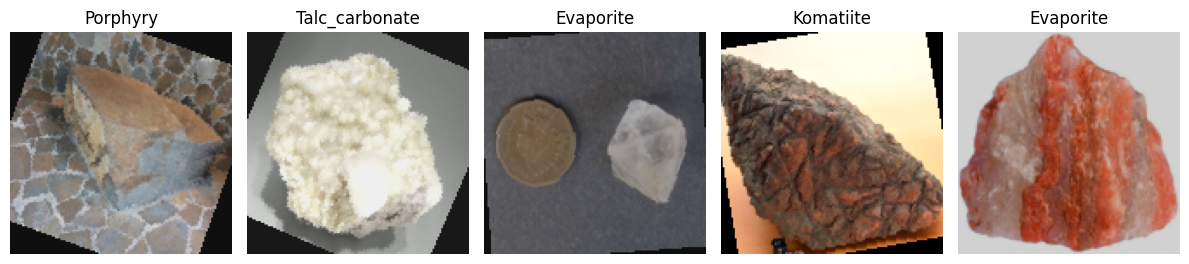

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].numpy().transpose(1,2,0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(train_ds.classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

## CNN ARCH

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 53):
        super().__init__()
        self.features = nn.Sequential(
            # Block-1: B, 3, 256, 256 → B, 32, 128, 128
            nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block-2: B, 32, 128, 128 → B, 64, 64, 64
            nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block-3: B, 64, 64, 64 → B, 128, 32, 32
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block-4: B, 128, 32, 32 → B, 256, 16, 16
            nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block-5: B, 256, 16, 16 → B, 512, 8, 8
            nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(), # B, 512
            nn.Dropout(p=0.4),
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        feats = self.features(x)
        logits = self.classifier(feats)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN(num_classes=53).to(device)

print("total param : ", sum(p.numel() for p in model.parameters()))
print(device)

total param :  4743381
cuda


## Optimizer

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

def train_one_epoch(model, loader):
    model.train()
    tl = 0
    ta = 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)
        loss.backward() # grad
        optimizer.step() # update

        tl+=loss.item() * x.size(0)
        ta+=accuracy(out, y) * x.size(0)

    return tl/len(loader.dataset), ta/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_acc  = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            total_acc  += accuracy(logits, y)

    return total_loss / len(loader), total_acc / len(loader)

## Checkpoint

In [ ]:
def save_checkpoint(model, optimizer, epoch, best_acc, path="checkpoint.pth"):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "best_acc": best_acc
    }
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    best_acc = checkpoint["best_acc"]

    print(f"✔ Checkpoint loaded — Resume from epoch {start_epoch}")
    return start_epoch, best_acc

## Train

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0
start_epoch = 1

In [ ]:
num_epochs = 35

for ep in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        save_checkpoint(model, optimizer, ep, best_acc, "best_model.pth")

    print(f"[Epoch {ep}] " f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc*100:.2f}% | " f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc*100:.2f}%")

[Epoch 1] Train Loss: 0.4862  Train Acc: 83.08% | Val Loss: 0.1463%  Val Acc: 93.17%


[Epoch 2] Train Loss: 0.4171  Train Acc: 85.08% | Val Loss: 0.1362%  Val Acc: 93.46%


[Epoch 3] Train Loss: 0.3814  Train Acc: 86.39% | Val Loss: 0.1323%  Val Acc: 94.04%


[Epoch 4] Train Loss: 0.3764  Train Acc: 87.08% | Val Loss: 0.1329%  Val Acc: 93.39%


[Epoch 5] Train Loss: 0.3644  Train Acc: 86.99% | Val Loss: 0.1308%  Val Acc: 93.75%


[Epoch 6] Train Loss: 0.3719  Train Acc: 86.60% | Val Loss: 0.1303%  Val Acc: 93.68%


[Epoch 7] Train Loss: 0.3528  Train Acc: 87.17% | Val Loss: 0.1312%  Val Acc: 93.38%


[Epoch 8] Train Loss: 0.3525  Train Acc: 86.95% | Val Loss: 0.1276%  Val Acc: 93.82%


[Epoch 9] Train Loss: 0.3654  Train Acc: 87.12% | Val Loss: 0.1249%  Val Acc: 93.82%


[Epoch 10] Train Loss: 0.3661  Train Acc: 86.73% | Val Loss: 0.1212%  Val Acc: 93.68%


[Epoch 11] Train Loss: 0.3352  Train Acc: 88.17% | Val Loss: 0.1252%  Val Acc: 93.68%


[Epoch 12] Train Loss: 0.3452  Train Acc: 87.73% | Val Loss: 0.1217%  Val Acc: 93.53%


[Epoch 13] Train Loss: 0.3423  Train Acc: 88.13% | Val Loss: 0.1251%  Val Acc: 93.31%


[Epoch 14] Train Loss: 0.3348  Train Acc: 88.69% | Val Loss: 0.1217%  Val Acc: 93.60%


[Epoch 15] Train Loss: 0.3448  Train Acc: 88.04% | Val Loss: 0.1192%  Val Acc: 93.46%


[Epoch 16] Train Loss: 0.3327  Train Acc: 87.47% | Val Loss: 0.1223%  Val Acc: 93.46%


[Epoch 17] Train Loss: 0.3238  Train Acc: 87.78% | Val Loss: 0.1230%  Val Acc: 93.68%


[Epoch 18] Train Loss: 0.3281  Train Acc: 87.86% | Val Loss: 0.1216%  Val Acc: 93.60%


[Epoch 19] Train Loss: 0.3255  Train Acc: 88.04% | Val Loss: 0.1209%  Val Acc: 93.75%


[Epoch 20] Train Loss: 0.3277  Train Acc: 87.95% | Val Loss: 0.1210%  Val Acc: 93.60%


[Epoch 21] Train Loss: 0.3381  Train Acc: 87.95% | Val Loss: 0.1213%  Val Acc: 93.53%


[Epoch 22] Train Loss: 0.3249  Train Acc: 88.04% | Val Loss: 0.1222%  Val Acc: 93.75%


[Epoch 23] Train Loss: 0.3217  Train Acc: 87.69% | Val Loss: 0.1224%  Val Acc: 93.60%


[Epoch 24] Train Loss: 0.3053  Train Acc: 88.43% | Val Loss: 0.1214%  Val Acc: 93.46%


[Epoch 25] Train Loss: 0.3271  Train Acc: 87.73% | Val Loss: 0.1244%  Val Acc: 93.46%


[Epoch 26] Train Loss: 0.3138  Train Acc: 88.17% | Val Loss: 0.1223%  Val Acc: 93.75%


[Epoch 27] Train Loss: 0.3080  Train Acc: 88.91% | Val Loss: 0.1223%  Val Acc: 93.53%


[Epoch 28] Train Loss: 0.3257  Train Acc: 88.08% | Val Loss: 0.1197%  Val Acc: 93.75%


[Epoch 29] Train Loss: 0.3344  Train Acc: 87.60% | Val Loss: 0.1201%  Val Acc: 93.60%


[Epoch 30] Train Loss: 0.3068  Train Acc: 88.60% | Val Loss: 0.1197%  Val Acc: 93.60%


[Epoch 31] Train Loss: 0.3030  Train Acc: 88.95% | Val Loss: 0.1192%  Val Acc: 93.90%


[Epoch 32] Train Loss: 0.3074  Train Acc: 88.39% | Val Loss: 0.1211%  Val Acc: 93.75%


[Epoch 33] Train Loss: 0.3004  Train Acc: 89.21% | Val Loss: 0.1207%  Val Acc: 93.60%


[Epoch 34] Train Loss: 0.3086  Train Acc: 89.04% | Val Loss: 0.1184%  Val Acc: 93.46%


[Epoch 35] Train Loss: 0.3242  Train Acc: 88.78% | Val Loss: 0.1228%  Val Acc: 93.60%


In [ ]:
save_checkpoint(model, optimizer, ep, best_acc, "best_model_new.pth")

## Train Curve

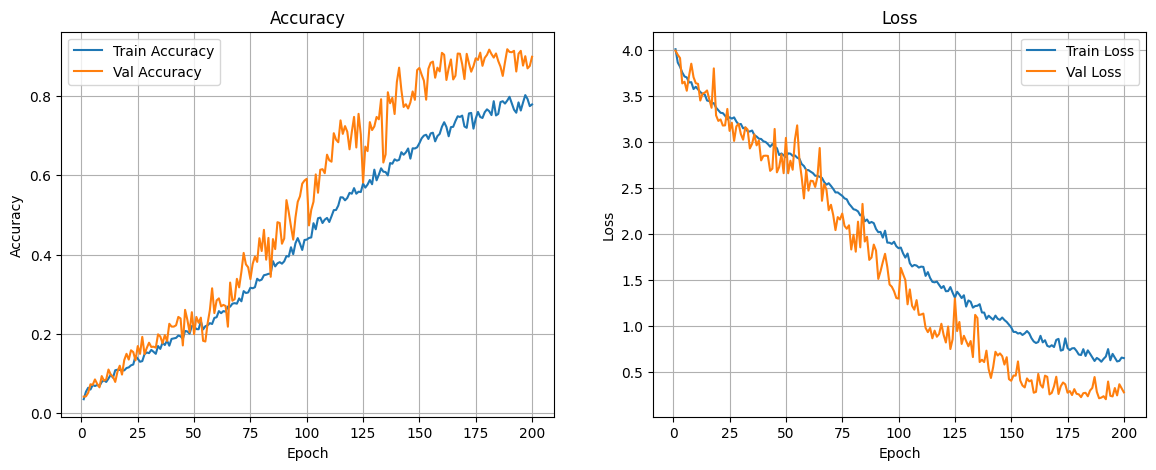

In [ ]:
epochs = range(1, 200+1)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


## Test Preidic

In [ ]:
start_epoch, best_acc = load_checkpoint(model, optimizer, "best_model.pth")

✔ Checkpoint loaded — Resume from epoch 4


In [ ]:
from google.colab import files

labels = train_ds.classes

def predict_image(model, transform, labels):
    """
    Upload satu gambar, prediksi kelas, dan tampilkan dengan matplotlib
    """
    # Upload gambar
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]  # Ambil file pertama

    # Preprocess
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Prediksi
    model.eval()
    with torch.no_grad():
        pred_class = torch.argmax(model(img_tensor), dim=1).item()

    pred_name = labels[pred_class]

    # matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediksi: {pred_name}", fontsize=16)
    plt.suptitle(f"File: {img_path}", fontsize=10, y=0.05)
    plt.show()
    os.remove(img_path)
    return pred_name


Saving Obsidian.png to Obsidian.png


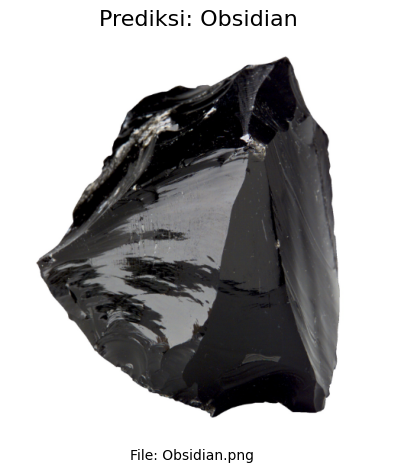

In [ ]:
prediksi = predict_image(model, test_tfms, labels)

Saving quartz diorite.png to quartz diorite.png


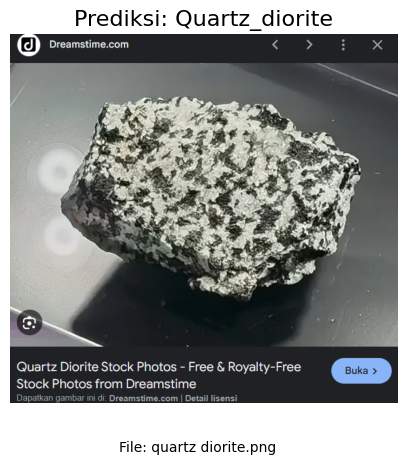

In [ ]:
prediksi = predict_image(model, test_tfms, labels)

Saving Eclogite.png to Eclogite.png


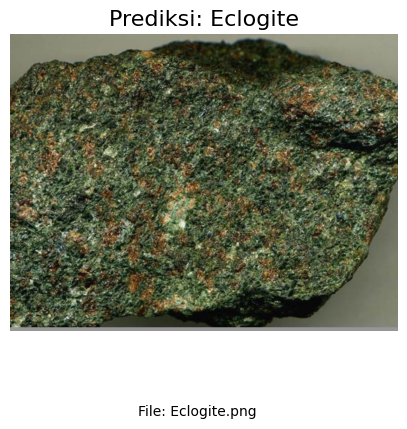

In [ ]:
prediksi = predict_image(model, test_tfms, labels)

Saving pumice.png to pumice.png


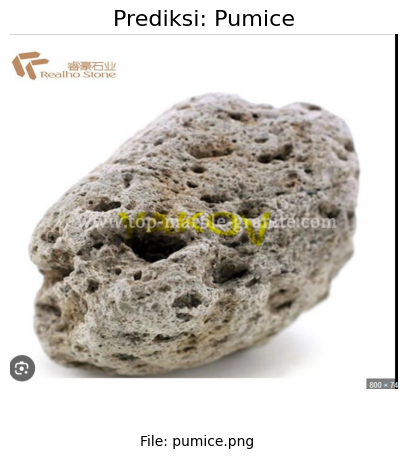

In [ ]:
prediksi = predict_image(model, test_tfms, labels)

Saving Screenshot 2025-11-25 035720.png to Screenshot 2025-11-25 035720.png


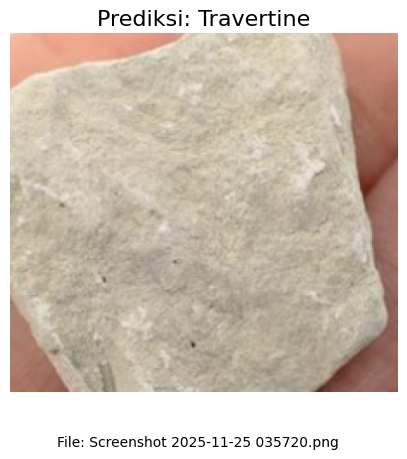

In [ ]:
prediksi = predict_image(model, test_tfms, labels)